<a href="https://colab.research.google.com/github/YehaoTian/Restaurants/blob/master/ImageStyleMergeV2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [104]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (14,14)
mpl.rcParams['axes.grid'] = False
import tensorflow as tf
import numpy as np


In [105]:
content_path = tf.keras.utils.get_file('v2-e64fb74925a7ce0f6e6780bd178f78db_1440w.jpg','https://pic2.zhimg.com/v2-e64fb74925a7ce0f6e6780bd178f78db_1440w.jpg')
style_path1 = tf.keras.utils.get_file('style1.jpg','https://storage.googleapis.com/khanhlvg-public.appspot.com/arbitrary-style-transfer/style23.jpg')
style_path2 = tf.keras.utils.get_file('flat,750x,075,f-pad,750x1000,f8f8f8.jpg','https://ih1.redbubble.net/image.476167148.5096/flat,750x,075,f-pad,750x1000,f8f8f8.jpg')

style_predict_path = tf.keras.utils.get_file('style_predict.tflite', 'https://tfhub.dev/google/lite-model/magenta/arbitrary-image-stylization-v1-256/int8/prediction/1?lite-format=tflite')
style_transform_path = tf.keras.utils.get_file('style_transform.tflite', 'https://tfhub.dev/google/lite-model/magenta/arbitrary-image-stylization-v1-256/int8/transfer/1?lite-format=tflite')

In [ ]:
# Function to load an image from a file, and add a batch dimension.
def load_img(path_to_img):
  img = tf.io.read_file(path_to_img)
  img = tf.io.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)
  img = img[tf.newaxis, :]

  return img

# Function to pre-process by resizing an central cropping it.
def preprocess_image(image, target_dim):
  # Resize the image so that the shorter dimension becomes 256px.
  shape = tf.cast(tf.shape(image)[1:-1], tf.float32)
  short_dim = min(shape)
  scale = target_dim / short_dim
  new_shape = tf.cast(shape * scale, tf.int32)
  image = tf.image.resize(image, new_shape)

  # Central crop the image.
  image = tf.image.resize_with_crop_or_pad(image, target_dim, target_dim)

  return image

# Load the input images.
content_image = load_img(content_path)
style_image1 = load_img(style_path1)
style_image2 = load_img(style_path2)

# Preprocess the input images.
preprocessed_content_image = preprocess_image(content_image, 384)
preprocessed_style_image1 = preprocess_image(style_image1, 256)
preprocessed_style_image2 = preprocess_image(style_image2, 256)

print('Style Image Shape:', preprocessed_style_image1.shape)
print('Content Image Shape:', preprocessed_content_image.shape)

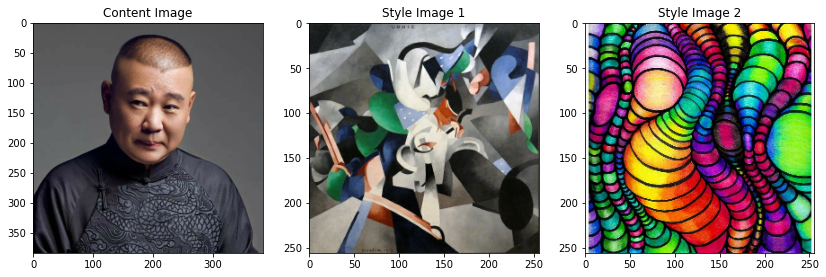

In [107]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

plt.subplot(1, 3, 1)
imshow(preprocessed_content_image, 'Content Image')

plt.subplot(1, 3, 2)
imshow(preprocessed_style_image1, 'Style Image 1')

plt.subplot(1, 3, 3)
imshow(preprocessed_style_image2, 'Style Image 2')

In [108]:
# Function to run style prediction on preprocessed style image.
def run_style_predict(preprocessed_style_image):
  # Load the model.
  interpreter = tf.lite.Interpreter(model_path=style_predict_path)

  # Set model input.
  interpreter.allocate_tensors()
  input_details = interpreter.get_input_details()
  interpreter.set_tensor(input_details[0]["index"], preprocessed_style_image)

  # Calculate style bottleneck.
  interpreter.invoke()
  style_bottleneck = interpreter.tensor(
      interpreter.get_output_details()[0]["index"]
      )()

  return style_bottleneck

# Calculate style bottleneck for the preprocessed style image.
style_bottleneck1 = run_style_predict(preprocessed_style_image1)
style_bottleneck2 = run_style_predict(preprocessed_style_image2)

print('Style Bottleneck Shape:', style_bottleneck1.shape)

Style Bottleneck Shape: (1, 1, 1, 100)


In [109]:
style_bottleneck = style_bottleneck1.copy()
for i in range(100):
    if i % 2 == 1:
        style_bottleneck[0, 0, 0, i] = (style_bottleneck2[0, 0, 0, i] + style_bottleneck[0, 0, 0, i]) / 2

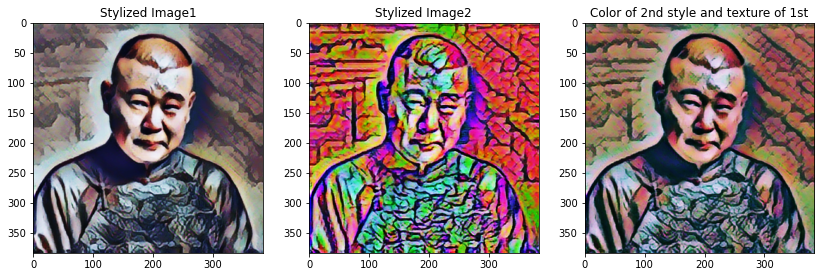

In [110]:
# Run style transform on preprocessed style image
def run_style_transform(style_bottleneck, preprocessed_content_image):
  # Load the model.
  interpreter = tf.lite.Interpreter(model_path=style_transform_path)

  # Set model input.
  input_details = interpreter.get_input_details()
  interpreter.allocate_tensors()

  # Set model inputs.
  interpreter.set_tensor(input_details[0]["index"], preprocessed_content_image)
  interpreter.set_tensor(input_details[1]["index"], style_bottleneck)
  interpreter.invoke()

  # Transform content image.
  stylized_image = interpreter.tensor(
      interpreter.get_output_details()[0]["index"]
      )()

  return stylized_image

# Stylize the content image using the style bottleneck.
plt.subplot(1, 3, 1)
stylized_image1 = run_style_transform(style_bottleneck1, preprocessed_content_image)
imshow(stylized_image1, 'Stylized Image1')

plt.subplot(1, 3, 2)
stylized_image2 = run_style_transform(style_bottleneck2, preprocessed_content_image)
imshow(stylized_image2, 'Stylized Image2')

plt.subplot(1, 3, 3)
stylized_image = run_style_transform(style_bottleneck, preprocessed_content_image)

# Visualize the output.
imshow(stylized_image, 'Color of 2nd style and texture of 1st')

In [111]:
import cv2
img = stylized_image[0, :, :, :] *255
img = img.astype(np.uint8)
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
# cv2.imwrite('4.jpg', img)